# Imports

In [1]:
from sklearn.preprocessing import (FunctionTransformer, 
                                   QuantileTransformer,
                                   MinMaxScaler,
                                   RobustScaler,
                                   StandardScaler,
                                   KBinsDiscretizer,
                                  )



In [2]:
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer, minmax_scale


# Load Images

In [3]:
def transform_image(arr, f, **kwargs):
    arr = np.array(arr)
    assert arr.ndim == 2
    transformed_images = []
    for i in range(arr.shape[1]):
        
        transformed_images_i = []
        
        for image in arr[:,i]:
            image_shape = image.shape
            transformed = f(image.flatten(), **kwargs)            
            #shape preserving tranfsormation
            if isinstance(transformed, np.ndarray):
                if np.prod(transformed.shape) == np.prod(image_shape):
                    transformed = transformed.reshape(image_shape)
                else:
                    pass
            
            transformed_images_i.append(transformed)
        
        transformed_images.append(transformed_images_i)
    
    images = np.array(transformed_images).T
    return images

class ImageTransformer(FunctionTransformer):
    def __init__(self, function):
        self.function = function
        super().__init__(lambda x: transform_image(x, function))

In [4]:
def get_histogram_stat(img, stat = np.mean):    
    #assert is black and white and 2d
    assert img.ndim == 2
    return stat(img)

def to_black_and_white(img, dtype = np.int16, asarray = True, normalize_range = (0,255)):
    """
    transforms the image to black and white one, with 2 channels only.
    its possible to normalize and cast, if an array is returned
    """
    if isinstance(img, PIL.BmpImagePlugin.BmpImageFile):
        arr = np.array(img.convert('L'))
    else:
        arr = img
    
    if normalize_range is None:
        arr = arr.astype(dtype)
    else:
        arr =  minmax_scale(arr, normalize_range, axis = None).astype(dtype)
        
    if asarray:
        return arr
    else:
        return Image.fromarray(arr)
        

def get_histogram_stat_vector(images, stat = np.mean, normalization_function = to_black_and_white):
    """
    allows vectorized operations on ImageLoader instance or collection of images/np.arrays
    """
    if isinstance(images, ImageLoader):
        results = images.map(lambda img: stat(normalization_function(img)))
    else:
        results = list(map(lambda img: stat(normalization_function(img)), images))
        
    return results

In [5]:
class ImageLoader():
    """
    loads images from path given a list of wildcards
    """
    def __init__(self, root_dir):
        
        
        label_paths = Path(root_dir).iterdir()
        #set labels based on parent folder
        all_items = []
        for label_path in label_paths:
            label = str(label_path).split("/")[-1]
            mask_paths = [str(i) for i in set(label_path.glob("*_mask*"))]
            
            image_paths = list(
                str(label_path) +"/"+ i.split("/")[-1].split("_mask")[0] + ".bmp" 
                for i in mask_paths
            )
            
            #keep only pairs that exist
            mask_paths = [mask_paths[i] for i in range(len(image_paths)) if Path(image_paths[i]).exists()]
            image_paths = [image_paths[i] for i in range(len(image_paths)) if Path(image_paths[i]).exists()]
            #
            labels = [label]*len(image_paths)
            items = list(zip(image_paths, mask_paths, labels))
            all_items += items
        
        self.items = all_items
        return
        
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        return {"image":Image.open(self.items[idx][0]), "mask": Image.open(self.items[idx][1]), "label":self.items[idx][2]}        
    
    def get_image_array(self, index):        
        image = Image.open(self.items[index][0])
        return np.array(image)
    
    def get_mask_array(self, index):
        mask = Image.open(self.items[index][1])
        mask_array = np.array(mask)
        assert len(np.unique(mask_array.flatten())) <= 2, "mask has more than two values"
        mask_array = (mask_array - mask_array.min())/(mask_array.max()-mask_array.min())
        return mask_array.astype(bool)
    
    def get_label(self, index):
        return self.items[index][2]
    
    def get_masked_image(self, index):
        return np.where(self.get_mask_array(index), self.get_image_array(index), 0)
    
    def plot_masked_image(self, index):
        plt.imshow(self.get_image_array(index), cmap = "gray")
        plt.imshow(self.get_masked_image(index), alpha = 0.5, cmap = "gray")
        return
    
    def get_masked_flat_image(self, index, return_index = False):
        image_flat = self.get_image_array(index).flatten()
        mask_flat = self.get_mask_array(index).flatten()        
        image_flat = image_flat[mask_flat]
        if not return_index:
            return image_flat
        else:
            return image_flat, mask_flat.nonzero()[0]
            
    def get_image_id(self, index):
        return self.items[index][0].split('/')[-1].split("_FLAIR")[0]
    
    def get_flair_id(self, index):
        return self.items[index][0].split('/')[-1].split("_FLAIR")[-1].split('.')[0]
    
    def map(self, function, attribute = 'image'):
        assert attribute in (None, "image","label","mask")
        if not attribute is None:
            vals = [i[attribute] for i in self]
        else:
            vals = [i for i in self]
        
        results = list(map(function, vals))
        return results
    
    

In [6]:
loader = ImageLoader("./Train")

In [7]:
all(loader.map(lambda x: np.array(x).ndim == 2))

True

'AVC'

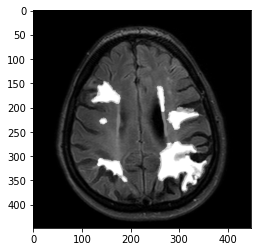

In [8]:
loader.plot_masked_image(212)
loader.get_label(212)

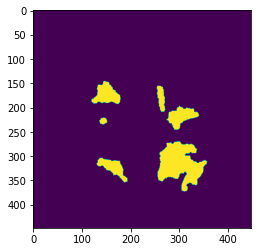

In [9]:
plt.imshow(loader.get_mask_array(212))

/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

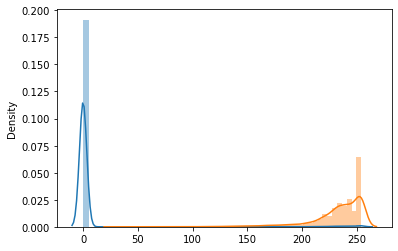

In [10]:
sns.distplot(loader.get_masked_image(0))
sns.distplot(loader.get_masked_flat_image(0))

# Preprocessing Pipelines

In [12]:
def mask_flat_image(img, mask):
    return img.flatten()[mask.flatten()]

In [15]:
images = [loader.get_image_array(i) for i in range(len(loader))]
masks = [loader.get_mask_array(i)  for i in range(len(loader))]
labels = [loader.get_label(i)  for i in range(len(loader))]
masked_flat_images = [loader.get_masked_flat_image(i)  for i in range(len(loader))]
flair = [loader.get_flair_id(i)  for i in range(len(loader))]
image_id = [loader.get_image_id(i)  for i in range(len(loader))]
normalized_images = transform_image(np.array(images).reshape(-1,1), lambda x: MinMaxScaler((0,255)).fit_transform(x.reshape(-1,1)).flatten())
flair_msk = [normalized_images[i][0] > 0 for i in range(len(loader))]
flair_masked_flat_images = [mask_flat_image(images[i], flair_msk[i])  for i in range(len(loader))]
normalized_flat_masked_flair = transform_image(np.array(flair_masked_flat_images).reshape(-1,1), lambda x: MinMaxScaler((0,255)).fit_transform(x.reshape(-1,1)).flatten())

/tmp/ipykernel_23861/1034085797.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  normalized_images = transform_image(np.array(images).reshape(-1,1), lambda x: MinMaxScaler((0,255)).fit_transform(x.reshape(-1,1)).flatten())
/tmp/ipykernel_23861/3403405197.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(transformed_images).T
/tmp/ipykernel_23861/1034085797.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes)

In [21]:
import pandas as pd
df = pd.DataFrame(images)
df.columns = ["image"]
df["mask"] = masks
df["masked_flat_image"] = masked_flat_images
df["normalized_flair_image"] = normalized_flat_masked_flair
df["flair_mask"] = flair_msk
df["tumor_relative_volume"] = df["mask"].apply(np.sum)/df["flair_mask"].apply(np.sum)
df["label"] = labels
df["flair_id"] = flair
df["flair_id"] = df["flair_id"].astype(int)
df["image_id"] = image_id

/home/alan/.local/lib/python3.8/site-packages/pandas/core/internals/construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [22]:
df["normalized_image"] = [i[0] for i in normalized_images]

In [23]:
df["binary_label"] = 0
df.loc[df["label"] == "EM", "binary_label"] = 1

In [24]:
df["normalized_image"].iloc[0].min()

0.0

In [25]:
#transform_image(df[["masked_flat_image"]], lambda x: entropy(x.astype(int)))

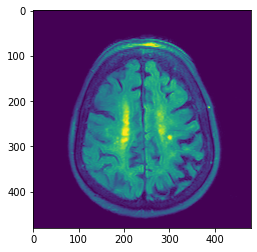

In [26]:
plt.imshow(df["normalized_image"].iloc[100])

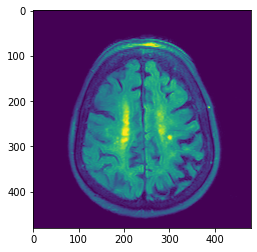

In [27]:
plt.imshow(images[100])

# Normalization Function

# Feature Extraction

In [28]:
from scipy.stats import entropy, skew, kurtosis

In [29]:
mean_transformer = ImageTransformer(np.mean)
sum_transformer = ImageTransformer(np.sum)
entropy_transformer = ImageTransformer(lambda x: entropy(x.astype(int)))
variance_transformer = ImageTransformer(np.var)
skew_transformer = ImageTransformer(skew)
kurtosis_transformer = ImageTransformer(kurtosis)
q0_transformer = ImageTransformer(lambda x: np.quantile(x, 0.))
q10_transformer = ImageTransformer(lambda x: np.quantile(x, 0.1))
q20_transformer = ImageTransformer(lambda x: np.quantile(x, 0.2))
q30_transformer = ImageTransformer(lambda x: np.quantile(x, 0.3))
q40_transformer = ImageTransformer(lambda x: np.quantile(x, 0.4))
q50_transformer = ImageTransformer(lambda x: np.quantile(x, 0.5))
q60_transformer = ImageTransformer(lambda x: np.quantile(x, 0.6))
q70_transformer = ImageTransformer(lambda x: np.quantile(x, 0.7))
q80_transformer = ImageTransformer(lambda x: np.quantile(x, 0.8))
q90_transformer = ImageTransformer(lambda x: np.quantile(x, 0.9))
q100_transformer = ImageTransformer(lambda x: np.quantile(x, 1))


# Train Model

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [31]:
#get ids for train and test

In [93]:
im_id_train, im_id_test = train_test_split(df["image_id"].unique(), train_size = 0.6)

In [94]:
train_msk = df["image_id"].isin(im_id_train)
test_msk = df["image_id"].isin(im_id_test)

In [95]:
df_train = df[train_msk]
df_test = df[test_msk]

In [96]:
df_train.shape,df_test.shape

((368, 11), (234, 11))

In [97]:
feature_cols = [
    "image",
    "mask",
    "flair_mask",
    "normalized_flair_image",
    "flair_id",
    "tumor_relative_volume",
    "masked_flat_image"
]
target = ["label"]

In [108]:
image_features = [
    "normalized_flair_image",
    "masked_flat_image",
    "image"
]
mask_features = [
    "mask",
    "flair_mask",
]
pass_features = [
    "flair_id",
    "tumor_relative_volume"
]

In [118]:
feature_extractor = ColumnTransformer(
    [
        ("areas",mean_transformer, mask_features),
        ("entropies", entropy_transformer, image_features),
        ("intensities", mean_transformer, image_features),
        ("variance", variance_transformer, image_features),
        ("skew", skew_transformer, image_features),
        ("kurtosis", kurtosis_transformer, image_features),
        ("q0", q0_transformer, image_features),
        #("q10", q10_transformer, image_features),
        ("q20", q20_transformer, image_features),
        #("q30", q30_transformer, image_features),
        #("q40", q40_transformer, image_features),
        ("q50", q50_transformer, image_features),
        #("q60", q60_transformer, image_features),
        #("q70", q70_transformer, image_features),
        ("q80", q80_transformer, image_features),
        #("q90", q90_transformer, image_features),
        ("q100", q100_transformer, image_features),     
        ("pass", "passthrough", pass_features)
    ]
)

In [127]:
model = SVC()

In [128]:
pipeline = make_pipeline(
    feature_extractor,
    QuantileTransformer(), #normalize extracted features between 0 and 1 by quantile
    model
)

In [129]:
pipeline.fit(df_train[feature_cols], df_train[target])

/home/alan/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (368). n_quantiles is set to n_samples.
  warnings.warn(
/home/alan/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('areas',
                                                  ImageTransformer(function=<function mean at 0x7f88b4053310>),
                                                  ['mask', 'flair_mask']),
                                                 ('entropies',
                                                  ImageTransformer(function=<function <lambda> at 0x7f887c03b670>),
                                                  ['normalized_flair_image',
                                                   'masked_flat_image',
                                                   'image']),
                                                 ('intensities',
                                                  ImageTransformer(function=<function mean at 0x7f...
                                                  ImageTransformer(function=<function <lambda> at 0x7f8876fdc8b0>),
                                                  ['normalized_flair_image',
                                                   'masked_flat_image',
                                                   'image']),
                                                 ('q100',
                                                  ImageTransformer(function=<function <lambda> at 0x7f8876fdcaf0>),
                                                  ['normalized_flair_image',
                                                   'masked_flat_image',
                                                   'image']),
                                                 ('pass', 'passthrough',
                                                  ['flair_id',
                                                   'tumor_relative_volume'])])),
                ('quantiletransformer', QuantileTransformer()),
                ('svc', SVC())])

# Evaluate Model

In [130]:
test_proba = pipeline.decision_function(df_test)
train_proba = pipeline.decision_function(df_train)

In [131]:
df_test["proba_pred"] = test_proba
df_train["proba_pred"] = train_proba

/tmp/ipykernel_23861/34115215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["proba_pred"] = test_proba
/tmp/ipykernel_23861/34115215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["proba_pred"] = train_proba


In [132]:
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [133]:
roc_auc_score(df_test["binary_label"], df_test["proba_pred"])

0.8146658415841584

In [134]:
roc_auc_score(df_train["binary_label"], df_train["proba_pred"])

0.9727935933300422